# Results for PCA+LSTM



In [14]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM


from keras.models import Sequential, model_from_json
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence


import warnings
import numpy as np
from collections import OrderedDict

import os

from lob_data_utils import lob, db_result, gdf_pca, model, stocks_numbers
from lob_data_utils.svm_calculation import lob_svm


sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
data_dir = 'res_gru/'
if_should_savefig = False # TODO
stock = 11869

In [17]:
df_res = pd.DataFrame()
for f in os.listdir(data_dir):
    d = pd.read_csv(os.path.join(data_dir, f))
    d['filename'] = [f for i in range(len(d))]
    if d['stock'].iloc[0] not in [stock]:
        continue
    number_of_units = []
    for i, row in d.iterrows():
        unit = row['unit'].split(':')[0][1:]
        number_of_units.append(unit)
    d['number_of_units'] = number_of_units
    d['number_of_units'] = d['number_of_units'].astype(int)
    df_res = df_res.append(d)

df_additional_res = pd.read_csv(f'res_gru_{stock}_different_step_numbers.csv_partial')
number_of_units = []
for i, row in df_additional_res.iterrows():
    unit = row['unit'].split(':')[0][1:]
    number_of_units.append(unit)
df_additional_res['number_of_units'] = number_of_units
df_additional_res['number_of_units'] = df_additional_res['number_of_units'].astype(int)
df_res = df_res.append(df_additional_res)

dd = pd.read_csv('res_gru_12255_different_step_numbers_3fold_.csv_partial')
df_res = df_res.append(dd)


df_res['diff'] = df_res['train_matthews'] - df_res['matthews']

print(df_res['r'].unique(), df_res['s'].unique())
df_log = pd.read_csv('res_log_que.csv')    

columns = ['matthews', 'test_matthews', 'stock', 'unit']
df_best = df_res.sort_values(by='matthews', ascending=False).groupby(['stock']).head(1)
df_best = pd.merge(df_best, df_log, on='stock', suffixes=['_lstm', '_log'])
df_best.index = df_best['stock']

[0.25 0.1  0.01] [0.25 0.1  0.5 ]


In [18]:
df_best[['r', 's', 'unit', 'n_steps', 'kernel_reg', 'train_matthews_lstm',
         'matthews_lstm', 'test_matthews_lstm', 'test_matthews_log', 'stock', 'filename']]

,r,s,unit,n_steps,kernel_reg,train_matthews_lstm,matthews_lstm,test_matthews_lstm,test_matthews_log,stock,filename
stock,,,,,,,,,,,
12255,0.1,0.1,"(8: tanh, 1)",1,0.0,0.136199,0.138213,0.099082,0.111629,12255,NaN
11869,0.1,0.5,"(32: tanh, 1)",1,0.0,0.126878,0.129617,0.102368,0.105285,11869,res_gru_pca_n_one_layer_11869_len24000_r0.1_s0...


In [19]:
df_res.sort_values(by='test_matthews', ascending=False).groupby(
    'stock').head(1)[['matthews', 'stock', 'test_matthews', 'r', 's', 'number_of_units', 'kernel_reg']]

,matthews,stock,test_matthews,r,s,number_of_units,kernel_reg
22,0.130342,12255,0.114262,0.1,0.1,NaN,0.00
11,0.123928,11869,0.110202,0.1,0.1,8.0,0.01


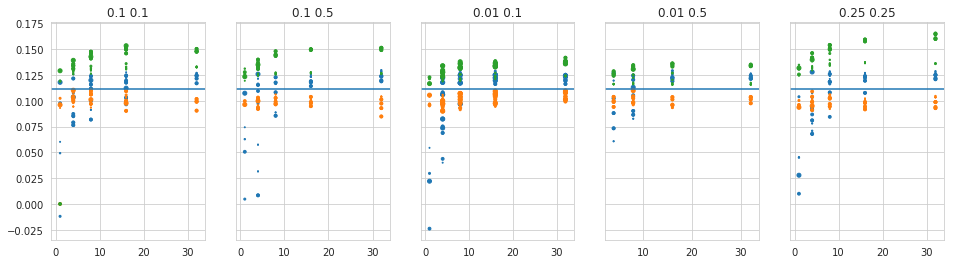

In [24]:
fig, ax = plt.subplots(1, 5, figsize=(16, 4), sharey=True)
i = 0
for r, s in stocks_numbers.rs_params:
    d = df_res[df_res['r'] == r] 
    d = d[d['s'] == s]
    d = d[d['stock'] == stock]
    ax[i].axhline(0.111)
    ax[i].scatter(d['number_of_units'], d['matthews'], d['n_steps'])
    ax[i].scatter(d['number_of_units'], d['test_matthews'], d['n_steps'])
    ax[i].scatter(d['number_of_units'], d['train_matthews'], d['n_steps'])

    ax[i].set_title(f'{r} {s}')
    i += 1

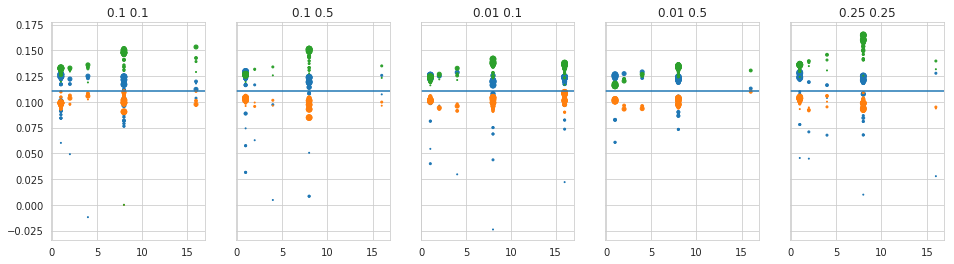

In [25]:
fig, ax = plt.subplots(1, 5, figsize=(16, 4), sharey=True)
i = 0
for r, s in stocks_numbers.rs_params:
    d = df_res[df_res['r'] == r] 
    d = d[d['s'] == s]
    d = d[d['stock'] == stock]
    ax[i].axhline(0.111)
    ax[i].scatter(d['n_steps'], d['matthews'], d['number_of_units'])
    ax[i].scatter(d['n_steps'], d['test_matthews'], d['number_of_units'])
    ax[i].scatter(d['n_steps'], d['train_matthews'], d['number_of_units'])

    ax[i].set_title(f'{r} {s}')
    i += 1

In [22]:
df_res.sort_values(by=['matthews','test_matthews'], ascending=False).groupby('n_steps').head(1)[[
    'matthews', 'test_matthews', 'n_steps', 'r', 's']]

,matthews,test_matthews,n_steps,r,s
10,0.138213,0.099082,1,0.1,0.1
11,0.136027,0.108390,2,0.1,0.1
18,0.134120,0.104521,8,0.1,0.1
12,0.131815,0.107470,4,0.1,0.1
14,0.131757,0.095863,16,0.1,0.1


In [23]:
d[['matthews', 'test_matthews', 'n_steps']].sort_values(by=['matthews','test_matthews'], ascending=False)

,matthews,test_matthews,n_steps
15,0.128587,0.103551,1
15,0.128587,0.103551,1
3,0.128377,0.102071,1
3,0.128377,0.102071,1
20,0.127790,0.094974,16
10,0.127542,0.103916,1
10,0.127542,0.103916,1
6,0.127540,0.103151,1
6,0.127540,0.103151,1
4,0.126934,0.100923,1
